In [1]:
important_families = ['lachnospiraceae', 'ruminococcaceae', 'rikenellaceae', 'porphyromonadaceae', 'prevotellaceae', 'bacteroidaceae', 'bifidobacteriaceae', 'coriobacteriaceae', 'veillonellaceae', 'clostridiaceae', 'enterobacteriaceae', 'streptococcaceae', 'peptostreptococcaceae', 'pasteurellaceae', 'acidaminococcaceae', 'verrucomicrobiaceae', 'desulfovibrionaceae', 'erysipelotrichaceae', 'sutterellaceae', 'victivallaceae']
len(important_families)

20

In [12]:
import gzip
from Bio import SeqIO
import re

# Function to load FASTA sequences and taxonomic annotations
def parse_data(fasta_file, taxonomy_file):
    sequences = []
    labels = []
    others_count = 0
    
    # Load taxonomy data into a dictionary for quick lookup
    taxonomy_dict = {}
    with gzip.open(taxonomy_file, 'rt') as f:
        for line in f:
            fields = line.strip().split('\t')
            accession = fields[0]
            taxonomy = fields[1]
            taxonomy_dict[accession] = taxonomy
    
    # Load sequences and labels
    with gzip.open(fasta_file, 'rt') as f:
        for record in SeqIO.parse(f, 'fasta'):
            accession = record.id
            if accession in taxonomy_dict:
                try:
                    family = re.search(r'f__([a-z]+)', taxonomy_dict[accession].lower()).group(1)
                except:
                    print('Error', taxonomy_dict[accession])
                    continue
                if family in important_families:
                    sequences.append(str(record.seq))
                    taxonomy = taxonomy_dict[accession]
                    labels.append(family)  # Extract family level taxonomy
                elif others_count < 50000:
                    sequences.append(str(record.seq))
                    taxonomy = taxonomy_dict[accession]
                    labels.append('others')
                    others_count += 1
    
    with open('sequences_small.txt', 'w') as f:
        for sequence, label in zip(sequences, labels):
            f.write(sequence + '\t' + label + '\n')

# Load data
fasta_file = 'gg_12_10.fasta.gz'
taxonomy_file = 'gg_12_10_taxonomy.txt.gz'
parse_data(fasta_file, taxonomy_file)

Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Firmicutes; c__Bacilli; o__; f__; g__; s__
Error k__Bacteria; p__Proteobacteria; c__Deltaprot

In [2]:
from smart_open import open

class Dataset():
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename):
            sequence, label = line.strip().split('\t')
            yield sequence, label

    def __len__(self):
        return sum(1 for line in open(self.filename))
    
# Load data
filename = 'sequences_small.txt'
dataset = Dataset(filename)
len(dataset)

320304

In [3]:
import numpy as np
labels = [y for x, y in dataset]
keys, counts = np.unique(labels, return_counts=True)
for key, count in zip(keys, counts):
    print(key, count)

bacteroidaceae 25779
bifidobacteriaceae 947
clostridiaceae 21219
coriobacteriaceae 2132
desulfovibrionaceae 1882
enterobacteriaceae 28225
erysipelotrichaceae 3912
lachnospiraceae 55807
others 50000
pasteurellaceae 8778
peptostreptococcaceae 3292
porphyromonadaceae 7022
prevotellaceae 12501
rikenellaceae 1469
ruminococcaceae 27326
streptococcaceae 57411
veillonellaceae 10206
verrucomicrobiaceae 2311
victivallaceae 85


In [8]:
# Keras text tokenizer
import keras_nlp

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=['A', 'C', 'G', 'T', 'N'],
    oov_token='N',
    special_tokens=['A', 'C', 'G', 'T'],
    special_tokens_in_strings=True,
    sequence_length=250
)

# Tokenize sequences
# seqs = [list(x) for x, y in dataset]
seqs = [x[:250] for x, y in dataset]
tokenized_seqs = tokenizer(seqs)

In [9]:
tokenized_seqs.shape

TensorShape([320304, 250])

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

labels = [y for x, y in dataset]
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Convert labels to one-hot encoding
labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

In [10]:
# Define the model
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Embedding(input_dim=tokenizer.vocabulary_size(), output_dim=16),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
model.fit(
    tokenized_seqs,
    labels_one_hot,
    batch_size=32,
    epochs=5,
    validation_split=0.2
)

Epoch 1/5
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 316s 39ms/step - accuracy: 0.6053 - loss: 1.2871 - val_accuracy: 0.8987 - val_loss: 0.3346
Epoch 2/5
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 311s 39ms/step - accuracy: 0.9249 - loss: 0.2778 - val_accuracy: 0.9416 - val_loss: 0.1840
Epoch 3/5
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 311s 39ms/step - accuracy: 0.9594 - loss: 0.1572 - val_accuracy: 0.9703 - val_loss: 0.1124
Epoch 4/5
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 310s 39ms/step - accuracy: 0.9712 - loss: 0.1149 - val_accuracy: 0.9773 - val_loss: 0.0909
Epoch 5/5
8008/8008 ━━━━━━━━━━━━━━━━━━━━ 311s 39ms/step - accuracy: 0.9759 - loss: 0.1009 - val_accuracy: 0.9782 - val_loss: 0.0925


In [12]:
# Save the model
model.save('model_lstm.keras')

# Predict the families in the zotu table

In [16]:
from Bio import SeqIO

# Function to load FASTA sequences and taxonomic annotations
zotus_data = {'id': [], 'seq': []}
with open('../PRJNA594535_unifrac/zotus.fa', 'r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        zotu_id = record.id
        zotus_data['id'].append(zotu_id)
        zotus_data['seq'].append(str(record.seq))

In [17]:
processed_data = tokenizer(zotus_data['seq'])

In [19]:
processed_data.shape

TensorShape([4208, 250])

In [20]:
predictions = model.predict(processed_data)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [24]:
# Parse the predictions
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

In [26]:
zotus_data['family'] = predicted_labels

In [28]:
import pandas as pd

df_zotus = pd.DataFrame(zotus_data)
# df_zotus.to_csv('zotus_family.csv', index=False)
df_zotus.head()

id                                                seq  \
0  Zotu1  GGGATTAGATACCCCTGTAGTCCTGGCAGTAAACGGTGCACGCTTG...   
1  Zotu2  AGGATTAGATACCCCTGTAGTCCTGGCAGTAAACGGTGCACGCTTG...   
2  Zotu3  AGGATTAGATACCCTGGTAGTCCACGCAGTAAACGATGATCACTAG...   
3  Zotu4  GGGATTAGATACCCTGGTAGTCCACGCAGTAAACGATGATCACTAG...   
4  Zotu5  AGGATTAGATACCCTGGTAGTCCACACAGTAAACGATGAATACTCG...   

               family  
0              others  
1              others  
2              others  
3  porphyromonadaceae  
4  porphyromonadaceae

In [29]:
df_zotus.groupby('family').size()

family
bacteroidaceae           60
bifidobacteriaceae        2
clostridiaceae            5
coriobacteriaceae        92
desulfovibrionaceae       1
enterobacteriaceae      106
erysipelotrichaceae      14
lachnospiraceae         200
others                 2070
porphyromonadaceae     1329
prevotellaceae          244
ruminococcaceae          30
streptococcaceae          2
veillonellaceae          22
verrucomicrobiaceae      31
dtype: int64

In [30]:
zotu_counts_per_sample = pd.read_csv('../PRJNA594535_unifrac/zotutab.txt', sep='\t', index_col=0)
zotu_counts_per_sample.head()

SRR10615586  SRR10615577  SRR10615582  SRR10615588  SRR10615580  \
#OTU ID                                                                    
Zotu1           3978         1421         3287         1008         2658   
Zotu145          536            0           20            0            3   
Zotu40           559            0          449            0          217   
Zotu44           670            0          626            1          303   
Zotu2           3566         1509         3103         1054         2601   

         SRR10615526  SRR10615561  SRR10615578  SRR10615583  SRR10615555  ...  \
#OTU ID                                                                   ...   
Zotu1            953         1646         2962         3247          845  ...   
Zotu145            0            0            6           27            0  ...   
Zotu40             0            8          231          418            0  ...   
Zotu44             0            0          460          661            0  ...   
Zotu2            952         1457         2724         2949          889  ...   

         SRR10615571  SRR10615558  SRR10615550  SRR10615522  SRR10615529  \
#OTU ID                                                                    
Zotu1           3044         2078         1803          331         2244   
Zotu145            0            0            0            0            0   
Zotu40           270           10            1            0            1   
Zotu44           403            0            0            0            0   
Zotu2           2894         2048         1697          281         2221   

         SRR10615554  SRR10615570  SRR10615532  SRR10615575  SRR10615576  
#OTU ID                                                                   
Zotu1           1687         1084         1714         3157         3196  
Zotu145            0            0            0          158          369  
Zotu40           182            0           35            0            0  
Zotu44             0            0            0            0            0  
Zotu2           1661         1003         1601         2952         3098  

[5 rows x 71 columns]

In [31]:
zotu_counts_per_sample['family'] = [df_zotus.loc[df_zotus['id'] == x, 'family'].values[0] for x in zotu_counts_per_sample.index]
zotu_counts_per_sample.head()

SRR10615586  SRR10615577  SRR10615582  SRR10615588  SRR10615580  \
#OTU ID                                                                    
Zotu1           3978         1421         3287         1008         2658   
Zotu145          536            0           20            0            3   
Zotu40           559            0          449            0          217   
Zotu44           670            0          626            1          303   
Zotu2           3566         1509         3103         1054         2601   

         SRR10615526  SRR10615561  SRR10615578  SRR10615583  SRR10615555  ...  \
#OTU ID                                                                   ...   
Zotu1            953         1646         2962         3247          845  ...   
Zotu145            0            0            6           27            0  ...   
Zotu40             0            8          231          418            0  ...   
Zotu44             0            0          460          661            0  ...   
Zotu2            952         1457         2724         2949          889  ...   

         SRR10615558  SRR10615550  SRR10615522  SRR10615529  SRR10615554  \
#OTU ID                                                                    
Zotu1           2078         1803          331         2244         1687   
Zotu145            0            0            0            0            0   
Zotu40            10            1            0            1          182   
Zotu44             0            0            0            0            0   
Zotu2           2048         1697          281         2221         1661   

         SRR10615570  SRR10615532  SRR10615575  SRR10615576          family  
#OTU ID                                                                      
Zotu1           1084         1714         3157         3196          others  
Zotu145            0            0          158          369  prevotellaceae  
Zotu40             0           35            0            0          others  
Zotu44             0            0            0            0          others  
Zotu2           1003         1601         2952         3098          others  

[5 rows x 72 columns]

In [32]:
human_samples = ['SRR10615525', 'SRR10615523', 'SRR10615521', 'SRR10615524', 'family']
zotu_counts_per_sample[human_samples].groupby('family').sum()
# Calculate the relative abundance of each family
rel_abundance = zotu_counts_per_sample[human_samples].groupby('family').sum() / zotu_counts_per_sample[human_samples].groupby('family').sum().sum()

In [41]:
rel_abundance.columns = pd.Index(['D1_H', 'D2_H', 'D3_H', 'D4_H'])

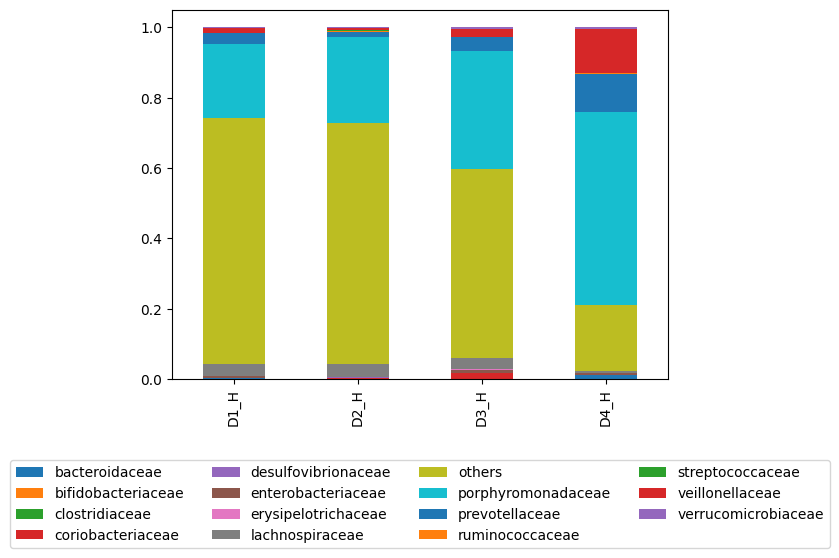

In [43]:
import matplotlib.pyplot as plt
# Plot the relative abundance of each family by sample
rel_abundance.T.plot(kind='bar', stacked=True)
# Show legend below the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)